### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 7
### Due: Saturday, Apr 2nd at 11.59pm CT
---

## Only one problem this week

This is a regression problem. Note of warning: the data I have provided have associated uncertainties, `yerr`. `sklearn` and `astroML` have different formats for using uncertainties; in `sklearn` fitting you can provide `sample_weight=1/yerr**2`, while in `astroML` fitting you can directly provide `y_error=yerr`.

1. Read in `hw7_data_1.npy`. The dataset should consist of $500$ samples. The first two columns are the two data features, `X`. The third column is the target labels, `y`, and the final column are the heteroscedastic uncertainties on the labels, `yerr`. Make a 2-panel scatter plot of the labels versus each feature.


2. Use multivariate linear regression on this data with its uncertainties (`astroML` rather than plain `sklearn` is the better option here). Print the best-fit intercept and slopes for the features. Make a prediction `Xgrid` over $50$ values from the min to the max value of each feature, and plot the best-fit model on a duplicate of the $2$-panel plot from (1); does this look like a good description of the data?


3. Make a new two-dimensional prediction meshgrid `Xgrid` over the $2$-D feature space, use your best-fit model to predict the labels, and make a $3$-D interactive plot showing the data and your best-fit over the entire space. You may find the following code useful.

4. Sticking with a linear model, now attempt a `GridSearchCV` procedure on the data to find the best `Ridge` regression hyper-parameters. Use the following `param_grid`:
```
ridge_params = {'alpha': [0.05,0.1,0.2,0.5,1.0], 'solver': ['svd', 'lsqr']}
```
What are the `best_params_` and the `best_score_` from this? Fit the data with the best options, and visualize interactively. Try `RidgeCV` also; what cross-validated `alpha_` does it return, and does this agree with `GridSeachCV`? *(Hint: remember to revert to inline matplotlib when you're done each time you make an interactive plot.)*


5. Perform Nadaraya-Watson regression on the data, using a Gaussian kernel with a bandwidth of $0.2$. Visualize interactively as before. How does this look compared to previous models?


6. Now model the data using Gaussian process regression and the default kernel. Check what the fit looks like with and with and without uncertainties accounted for. *(Hint: GPR in `sklearn` takes an `alpha` parameter equal to `(yerr/y)**2`.)*


7. Let's look finally at polynomial fitting. Fit a $4$th degree polynomial to the data. Print the best-fit regression coefficients, predict on the 2D meshgrid, and visualize interactively as before. How does this look compared to the linear model and GPR models?


8. Sticking with polynomial fitting, let's find the optimal hyper-parameters through cross-validation. 
- Using `sklearn.model_selection.train_test_split`, first do a train-test split with a `test_size` of $20\%$. Then split out a $20\%$ cross-validation set from the training set (leaving a somewhat smaller set to use for training). Note that you'll need to simultaneously split out `yerr` as well by just providing this as another array to `train_test_split`.
- Compute the training and cross-validation rms errors (and from those, the BIC values) as a function of polynomial degree from $1$ to $10$ inclusive. Plot the rms errors and BIC values as a function of the polynomial degree. 
- Choose the optimal polynomial degree, and train on all training data from the first `train_test_split` operation. Predict the labels of the held-out test set, and finally compute the testing rms error.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV, Ridge
from astroML.linear_model import NadarayaWatson
from sklearn.gaussian_process import GaussianProcessRegressor
from astroML.linear_model import PolynomialRegression
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format='retina'

### Part 1.1

In [2]:
datadir = '../../../homeworks/hw_data/'
rawdata = np.load(datadir+'hw7_data_1.npy')

X = rawdata[:,0:2]
y = rawdata[:,2]
yerr = rawdata[:,3]

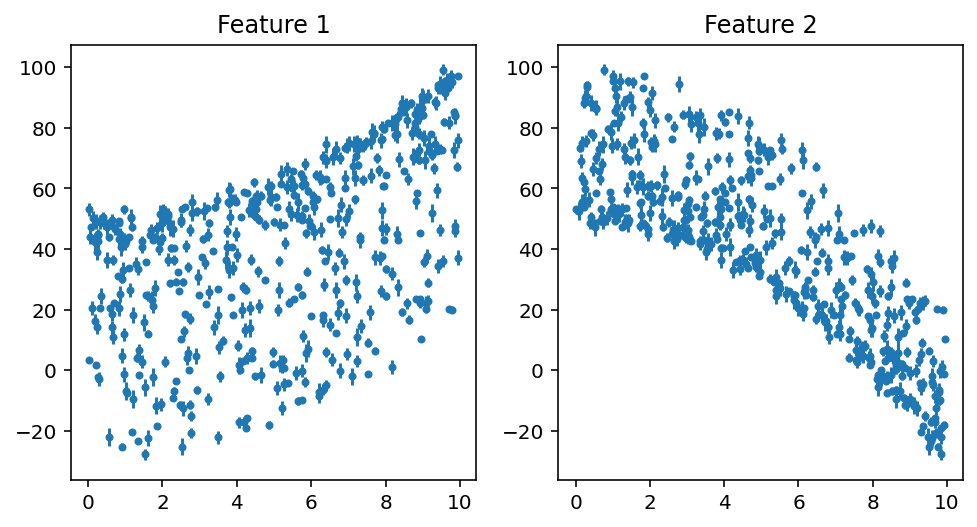

In [3]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('Feature 1')
plt.errorbar(X[:,0],y,yerr,fmt='.')
plt.subplot(1,2,2)
plt.title('Feature 2')
plt.errorbar(X[:,1],y,yerr,fmt='.')
plt.show()

### Part 1.2

In [4]:
"""
Use multivariate linear regression on this data with its uncertainties (astroML rather than plain sklearn is the 
better option here). Print the best-fit intercept and slopes for the features. Make a prediction Xgrid over  50 
values from the min to the max value of each feature, and plot the best-fit model on a duplicate of the  
2 -panel plot from (1); does this look like a good description of the data?
"""

model = LinearRegression(fit_intercept=True) 
model.fit(X, y, yerr)

x1 = np.linspace(min(X[:,0]),max(X[:,0]),50)
x2 = np.linspace(min(X[:,1]),max(X[:,1]),50)
x1grid, x2grid = np.meshgrid(x1,x2)
Xgrid = np.array([np.hstack(x1grid),np.hstack(x2grid)]).T

ypred = model.coef_[0]+Xgrid[:,0]*model.coef_[1]+Xgrid[:,1]*model.coef_[2]

print(f'Y intercept = {model.coef_[0]}')
print(f'Model x1 slope {model.coef_[1]}')
print(f'Model x2 slope {model.coef_[2]}')

Y intercept = 57.10102323299548
Model x1 slope 4.948730161178384
Model x2 slope -8.30023407006448


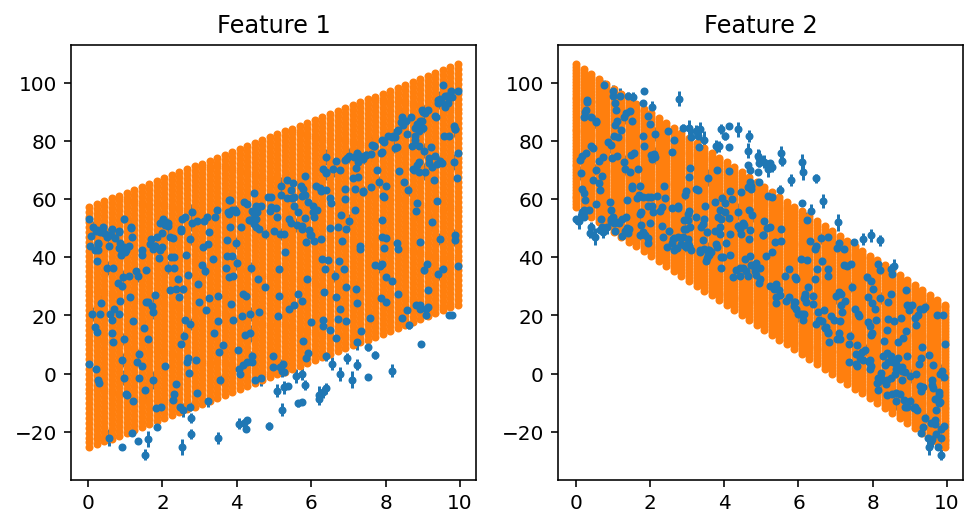

In [5]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('Feature 1')
plt.errorbar(X[:,0],y,yerr,fmt='.')
plt.plot(Xgrid[:,0],ypred,'.')

plt.subplot(1,2,2)
plt.title('Feature 2')
plt.errorbar(X[:,1],y,yerr,fmt='.')
plt.plot(Xgrid[:,1],ypred,'.')
plt.show()


This is an okay prediction, but this strictly linear fitting does a poor job of getting intermediate values between minimums and maximums, as there is some sort of 'bowing' that should be apparent in a 3d plot

SRT: This is not the best representation of the model. The question asked for an Xgrid from min to max over each feature. So we should be looking at a single line in each plot, not the projection of a hyperplane prediction. -2

### Part 1.3

<IPython.core.display.Javascript object>


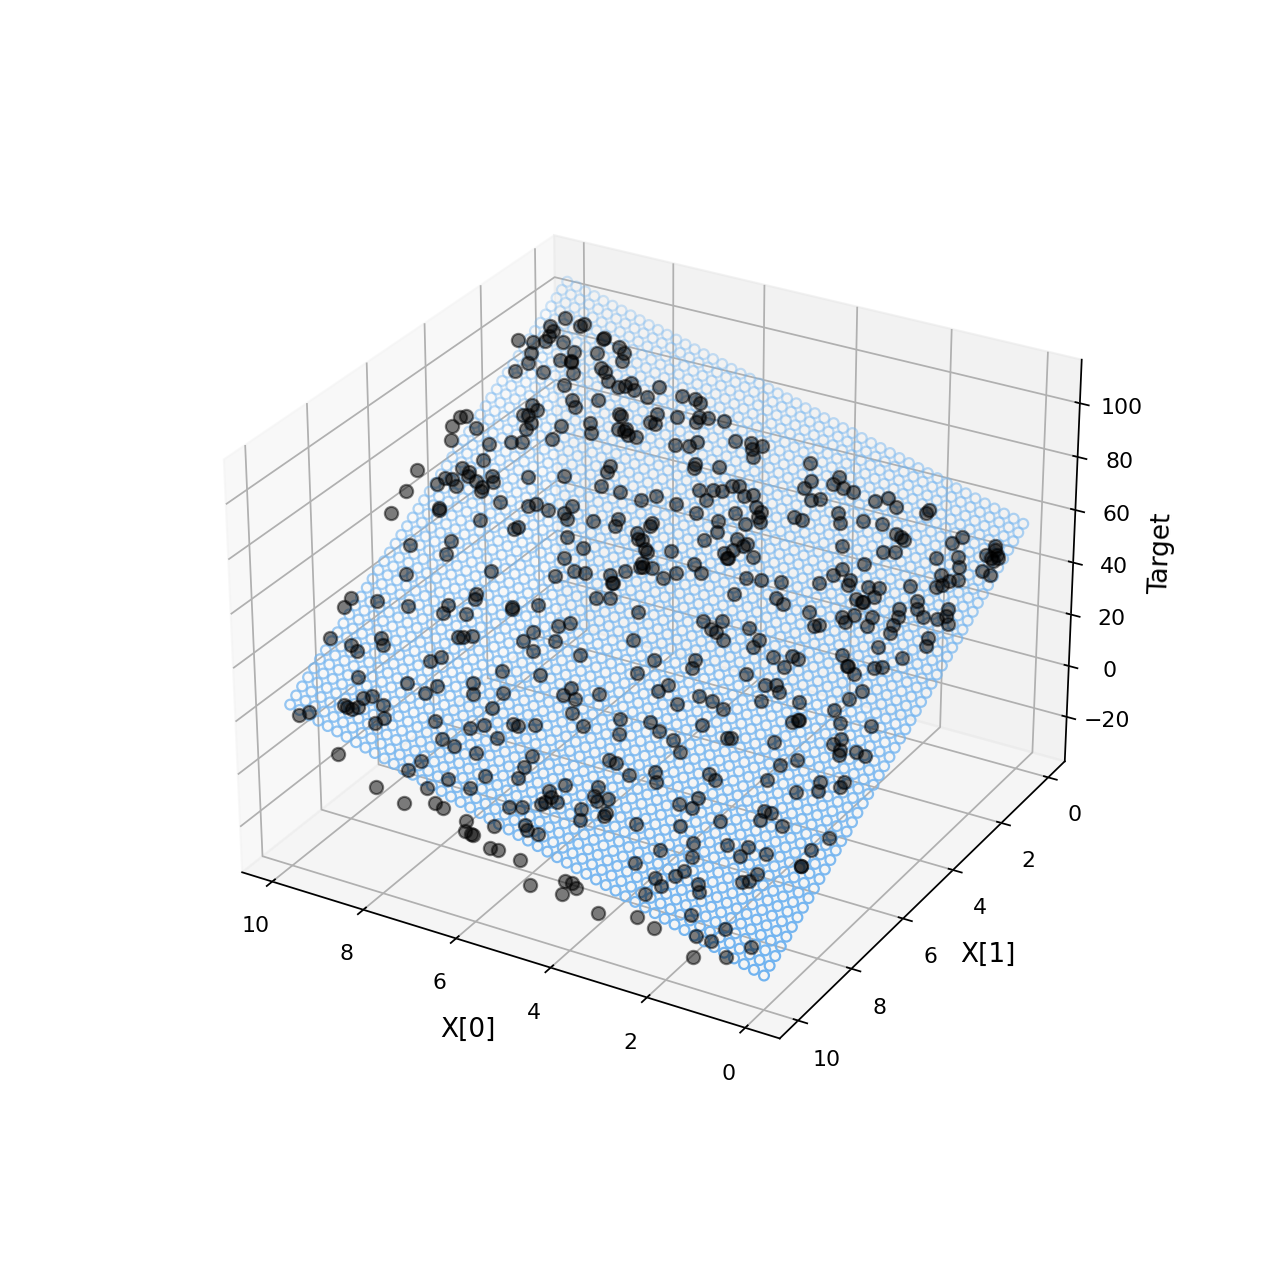

In [7]:
# Makes the plot interactive. 
# You can pan the image.
%matplotlib notebook  
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(X[:,0],X[:,1], y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(Xgrid[:,0], Xgrid[:,1], ypred, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)

SRT: Excellent!

### Part 1.4

In [8]:
"""
Sticking with a linear model, now attempt a GridSearchCV procedure on the data to find the best Ridge 
regression hyper-parameters. Use the following param_grid:
ridge_params = {'alpha': [0.05,0.1,0.2,0.5,1.0], 'solver': ['svd', 'lsqr']}

What are the best_params_ and the best_score_ from this? Fit the data with the best options, and visualize 
interactively. Try RidgeCV also; what cross-validated alpha_ does it return, and does this agree with 
GridSeachCV? (Hint: remember to revert to inline matplotlib when you're done each time you make an 
interactive plot.)
""";

In [9]:
ridge_params = {'alpha': [0.05,0.1,0.2,0.5,1.0], 'solver': ['svd', 'lsqr']}
grid = GridSearchCV(Ridge(),param_grid=ridge_params,)
grid.fit(X,y,sample_weight=1/yerr**2)

ridgeCV = RidgeCV(alphas=ridge_params['alpha'])
ridgeCV.fit(X,y,sample_weight=1/yerr**2)

print(f'Best parameter values (GridSearch): {grid.best_params_}')
print(f'Best score (GridSearch): {grid.best_score_}')

print(f'Best parameter values (RidgeCV): alpha={ridgeCV.alpha_}')
print(f'Best score (RidgeCV): {grid.best_score_}')

#These two things return the exact same results!

Best parameter values (GridSearch): {'alpha': 1.0, 'solver': 'lsqr'}
Best score (GridSearch): 0.929182742615996
Best parameter values (RidgeCV): alpha=1.0
Best score (RidgeCV): 0.929182742615996


SRT: Awesome

In [10]:
rmodel = Ridge(alpha=grid.best_params_['alpha'],solver=grid.best_params_['solver'])
rmodel.fit(X,y,sample_weight=1/yerr**2)

yRpred = rmodel.intercept_+Xgrid[:,0]*rmodel.coef_[0]+Xgrid[:,1]*rmodel.coef_[1]

In [11]:
#Print difference between linear, Ridge fitting
print(np.average(yRpred-ypred))

-0.0004069402156984424


<IPython.core.display.Javascript object>


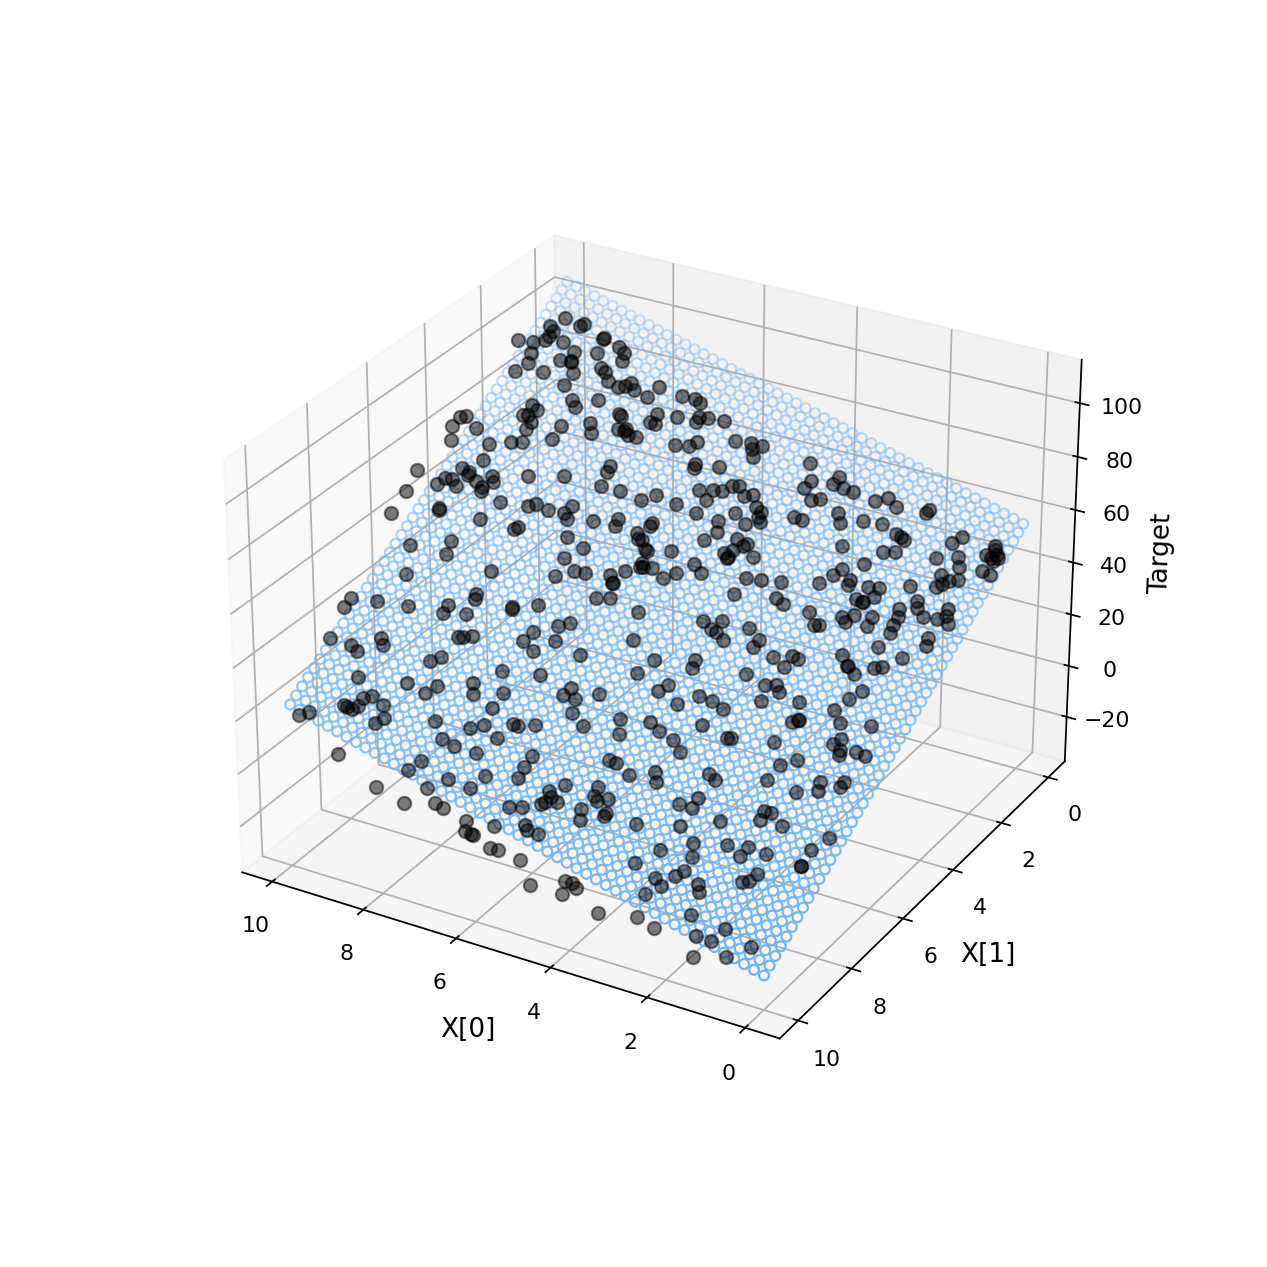

In [12]:
# Makes the plot interactive. 
# You can pan the image.
%matplotlib notebook  
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(X[:,0],X[:,1], y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(Xgrid[:,0], Xgrid[:,1], yRpred, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)

### Part 1.5

In [13]:
'''
Perform Nadaraya-Watson regression on the data, using a Gaussian kernel with a bandwidth of  0.2 
Visualize interactively as before. How does this look compared to previous models?
'''
nwModel = NadarayaWatson(kernel='gaussian', h=0.5)
nwModel.fit(X,y,yerr)

nwPred = nwModel.predict(Xgrid)

<IPython.core.display.Javascript object>


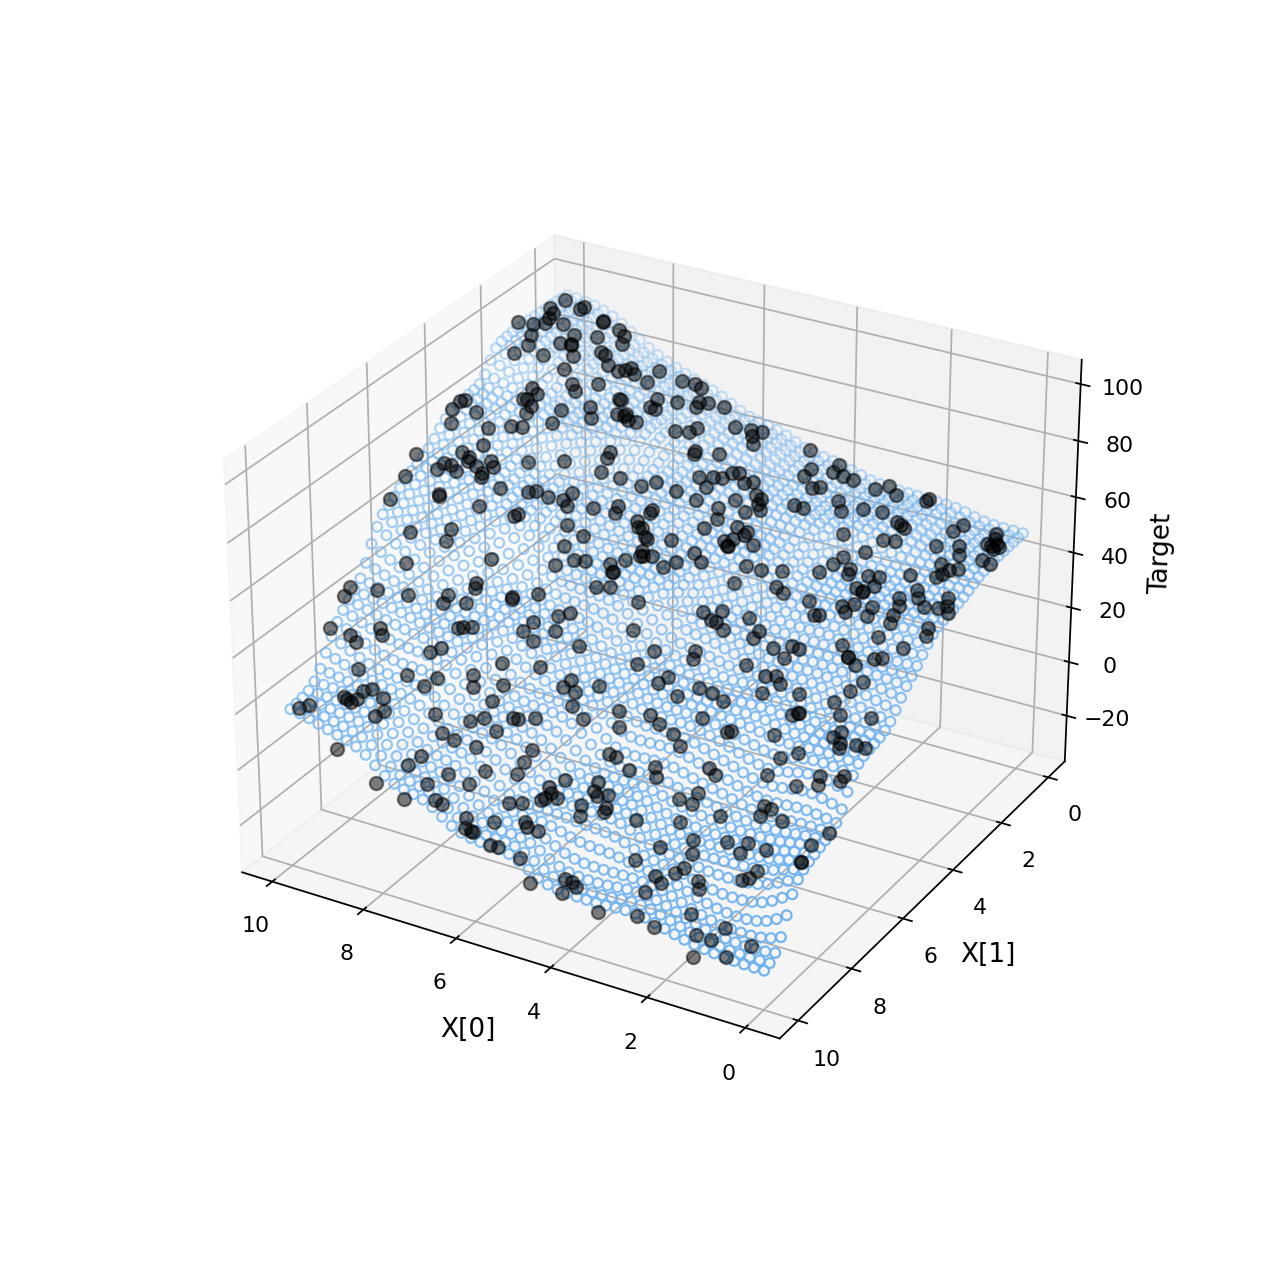

In [14]:
# Makes the plot interactive. 
# You can pan the image.
%matplotlib notebook  
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(X[:,0],X[:,1], y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(Xgrid[:,0], Xgrid[:,1], nwPred, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)

This fits the data FAR better than the other linear models. However, it looks to be fitting TOO well. There are little bumps that are likely due to uncertainties that this model will fit for. This is almost certainly overfitting

SRT: Agreed. Good commentary.

### Part 1.6

In [16]:
"""
Now model the data using Gaussian process regression and the default kernel. Check what the fit looks like with 
and with and without uncertainties accounted for. (Hint: GPR in sklearn takes an alpha parameter equal to 
(yerr/y)**2.)Now model the data using Gaussian process regression and the default kernel. Check what the fit looks
like with and with and without uncertainties accounted for. 
(Hint: GPR in sklearn takes an alpha parameter equal to (yerr/y)**2.)
"""
#With uncertainties
gpU = GaussianProcessRegressor(alpha=(yerr/y)**2)
gpU.fit(X,y)
gpUpred, gpUdypred = gpU.predict(Xgrid, return_std=True)


#Without
gpN = GaussianProcessRegressor()
gpN.fit(X,y)
gpNpred, gpNdypred = gpN.predict(Xgrid, return_std=True)


Accounting for uncertainties


<IPython.core.display.Javascript object>


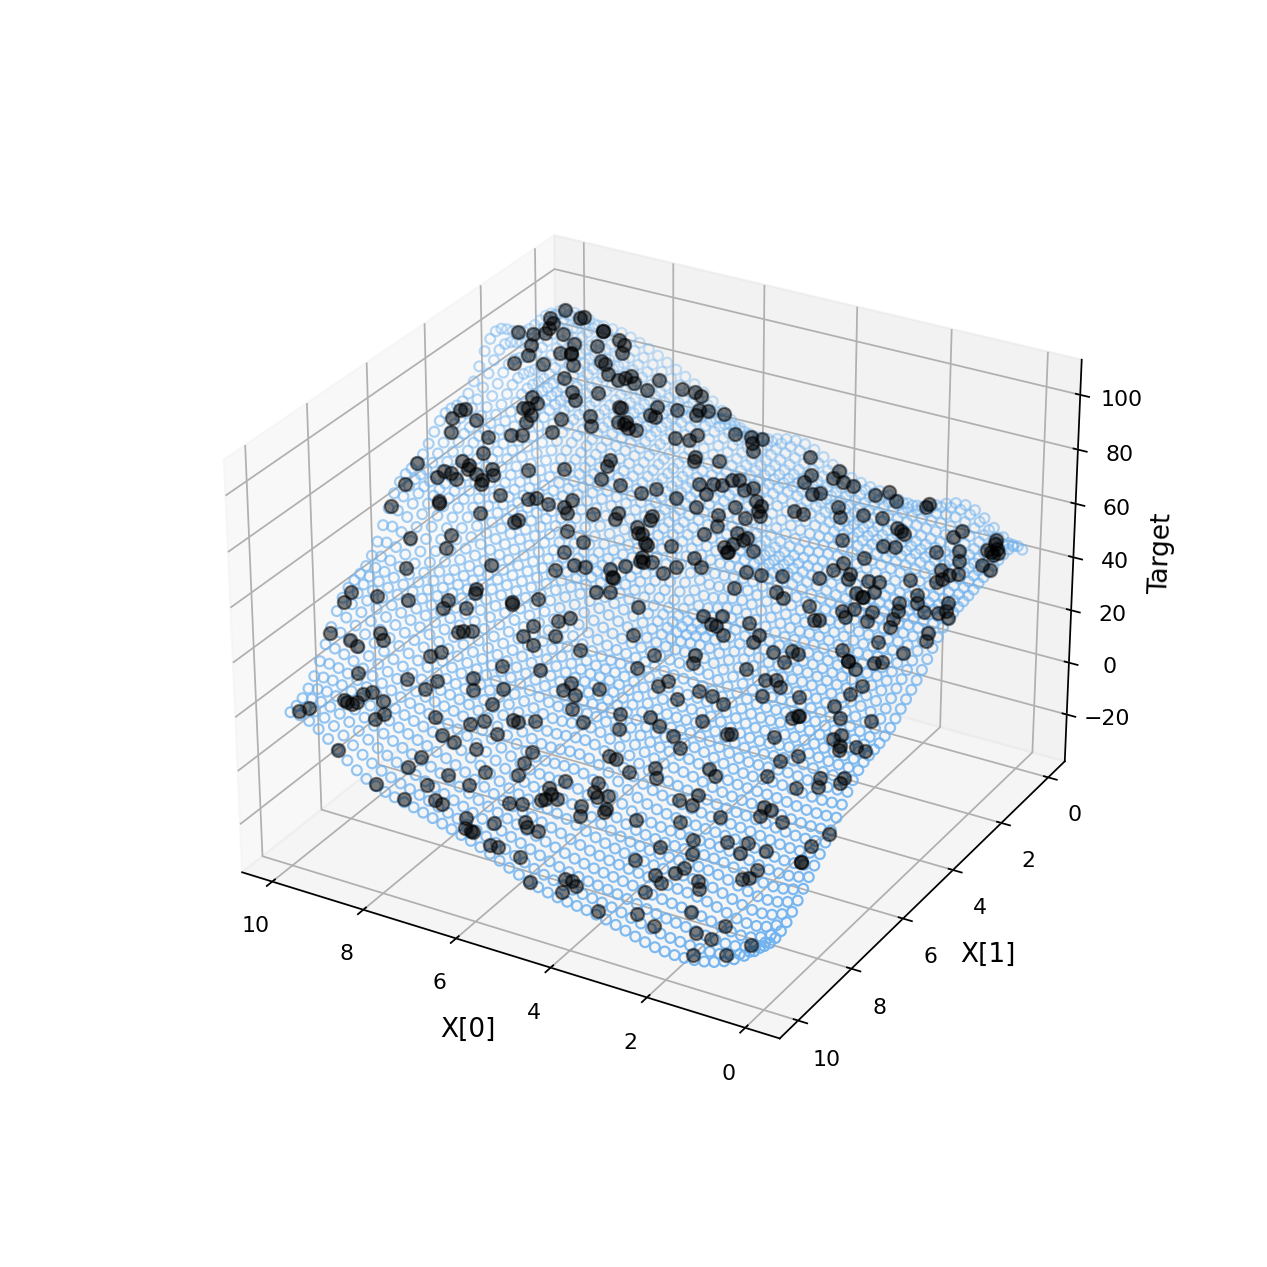

In [29]:
# Makes the plot interactive. 
# You can pan the image.
%matplotlib notebook  

print('Accounting for uncertainties')
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(X[:,0],X[:,1], y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(Xgrid[:,0], Xgrid[:,1], gpUpred, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)

Not accounting for uncertainties


<IPython.core.display.Javascript object>


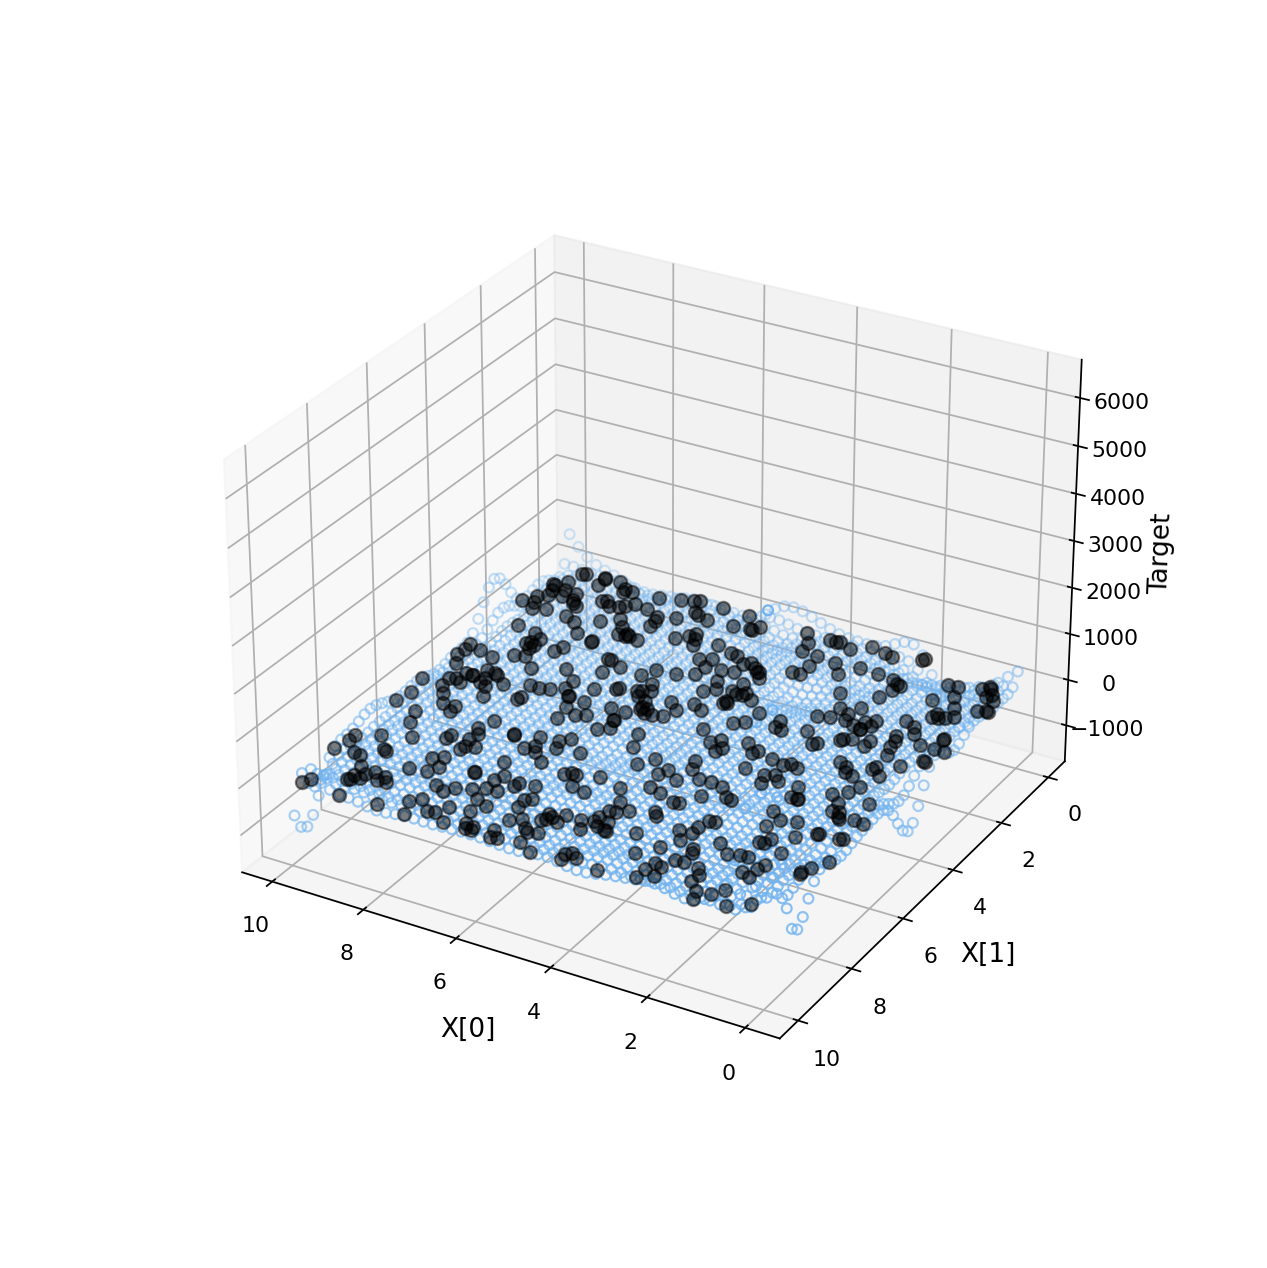

In [30]:
# Makes the plot interactive. 
# You can pan the image.
%matplotlib notebook  
print('Not accounting for uncertainties')
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(X[:,0],X[:,1], y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(Xgrid[:,0], Xgrid[:,1], gpNpred, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)

### Part 1.7

In [19]:
"""
Let's look finally at polynomial fitting. Fit a  4 th degree polynomial to the data. Print the best-fit 
regression coefficients, predict on the 2D meshgrid, and visualize interactively as before. 
How does this look compared to the linear model and GPR models?
"""
pn_model = PolynomialRegression(4) # fit 3rd degree polynomial
pn_model.fit(X,y,yerr)

pn_pred = pn_model.predict(Xgrid)

<IPython.core.display.Javascript object>


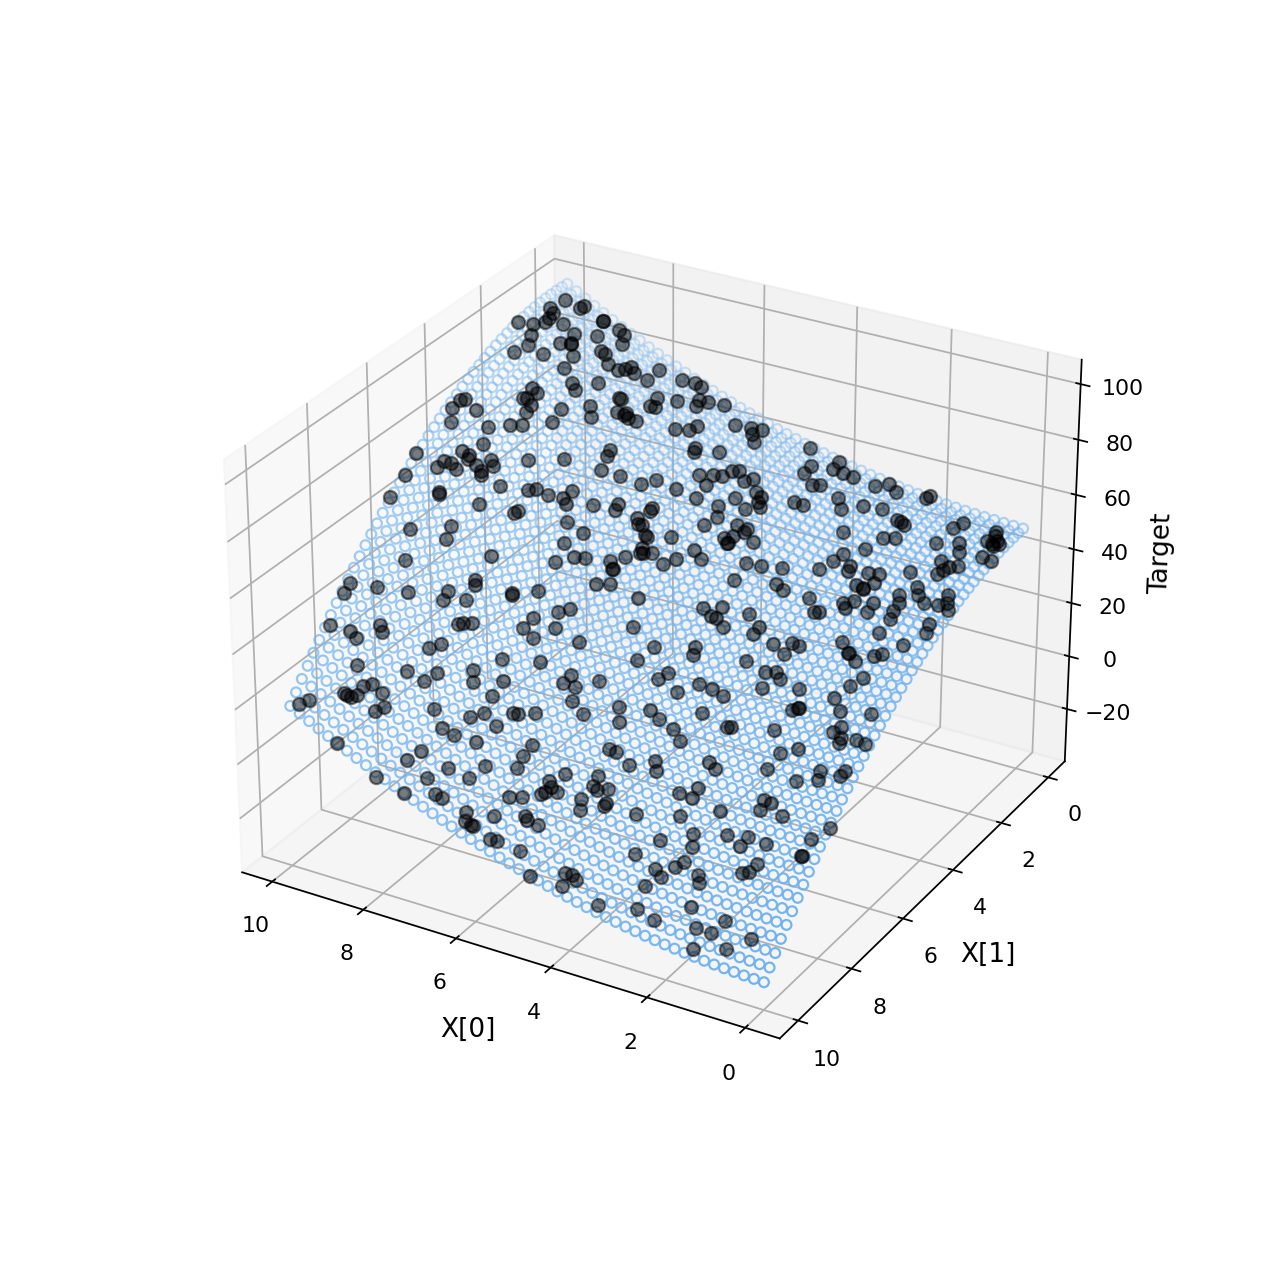

In [31]:
# Makes the plot interactive. 
# You can pan the image.
%matplotlib notebook  
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(X[:,0],X[:,1], y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(Xgrid[:,0], Xgrid[:,1], pn_pred, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)


Compared with the other models, this one looks fantastic! It gets the overall trend in the dataset while not fitting for every point and every little bump that might be caused by uncertainty.

In [21]:
%matplotlib inline

### Part 1.8

In [22]:
"""Sticking with polynomial fitting, let's find the optimal hyper-parameters through cross-validation.
Using sklearn.model_selection.train_test_split, first do a train-test split with a test_size of  20% . 
Then split out a  20%  cross-validation set from the training set (leaving a somewhat smaller set to 
use for training). Note that you'll need to simultaneously split out yerr as well by just providing this as 
another array to train_test_split.

Compute the training and cross-validation rms errors (and from those, the BIC values) as a 
function of polynomial degree from  1  to  10  inclusive. Plot the rms errors and BIC values as a 
function of the polynomial degree.

Choose the optimal polynomial degree, and train on all training data from the first train_test_split operation. 
Predict the labels of the held-out test set, and finally compute the testing rms error.
"""

Xfulltrain,Xtest,yfulltrain,ytest,yerrfulltrain,yerrtest = train_test_split(X,y,yerr,test_size=0.2)
print(len(yerrtest)/(len(yerrfulltrain)+len(yerrtest)))

Xtrain,Xcross,ytrain,ycross,yerrtrain,yerrcross = train_test_split(Xfulltrain,yfulltrain,yerrfulltrain,test_size=0.2)
print(len(Xtrain)/(len(Xtrain)+len(Xtest)+len(Xcross)))
#Should be 0.8*0.8 = 0.64

0.2
0.64


In [23]:
t = PolynomialRegression(degree=3)

def BIC(model,X,y,yerr):
    #Calculate Chi2
    chi2 = np.sum( (model.predict(X)-y)**2 / yerr**2 ) 
    
    return chi2 + model.degree * np.log(len(X))
    

t_rms = []
cv_rms = []

t_bic = []
cv_bic = []
    
for n in np.arange(1,11):
    #Create model, then fit with training set
    mod = PolynomialRegression(degree=n)
    mod.fit(Xtrain,ytrain,yerrtrain)
    
    #I was a bit confused on if I needed to encorporate yerror in rms error.
    #I decided that since BIC calculates with yerror that I would
    #use what was in lecture 17, and NOT encorporate the yerr in rms error
    
    #Calculate rms errors
    res2 = np.square(mod.predict(Xtrain)-ytrain)
    t_rms.append(np.sqrt(np.sum(res2)/len(Xtrain)))
    
    #Calculate rms on CC data
    res2 = np.square(mod.predict(Xcross)-ycross)
    cv_rms.append(np.sqrt(np.sum(res2)/len(Xcross)))
    
    t_bic.append(BIC(mod,Xtrain,ytrain,yerrtrain))
    cv_bic.append(BIC(mod,Xcross,ycross,yerrcross))
    

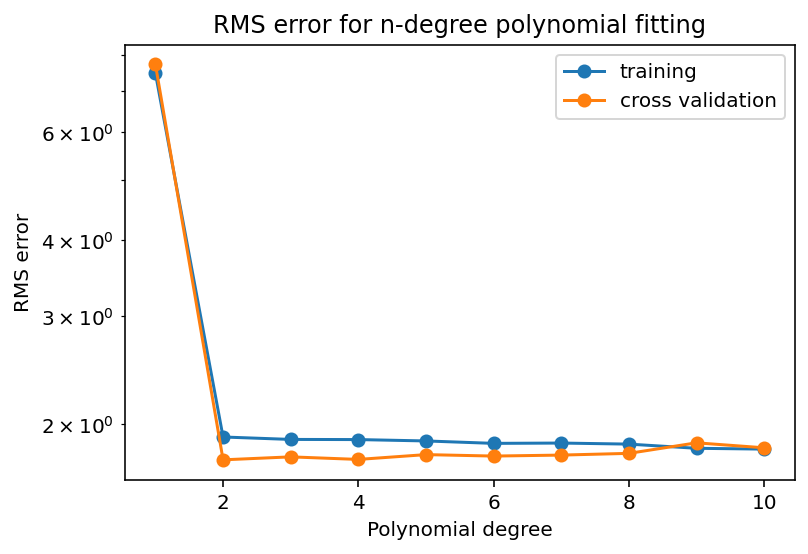

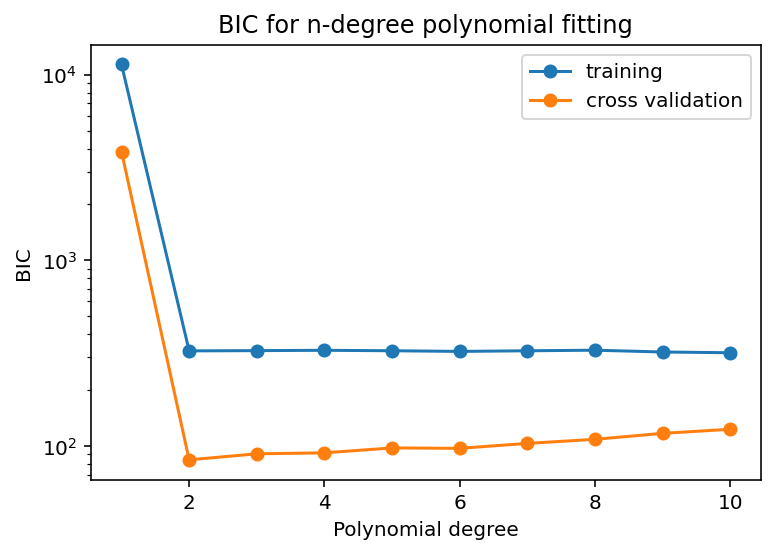

Lowest BIC is degree-2 polynomial


In [24]:
plt.plot(np.arange(1,11),t_rms,'o-',label='training')
plt.plot(np.arange(1,11),cv_rms,'o-',label='cross validation')
plt.title('RMS error for n-degree polynomial fitting')
plt.yscale('log')
plt.xlabel('Polynomial degree')
plt.ylabel('RMS error')
plt.legend()
plt.show()

plt.plot(np.arange(1,11),t_bic,'o-',label='training')
plt.plot(np.arange(1,11),cv_bic,'o-',label='cross validation')
plt.title('BIC for n-degree polynomial fitting')
plt.yscale('log')
plt.xlabel('Polynomial degree')
plt.ylabel('BIC')
plt.legend()
plt.show()

best_degree = np.argmin(cv_bic)+1
print(f'Lowest BIC is degree-{best_degree} polynomial')

In [25]:
#Xfulltrain,Xtest,yfulltrain,ytest,yerrfulltrain,yerrtest
mod = PolynomialRegression(degree=best_degree)
mod.fit(Xfulltrain,yfulltrain,yerrfulltrain)

#Calculate rms on test data
res2 = np.square(mod.predict(Xtest)-ytest)
test_rms = np.sqrt(np.sum(res2)/len(Xtest))

print(f'The final test RMS error with a degree-{best_degree} polynomial: {test_rms}')

The final test RMS error with a degree-2 polynomial: 2.102292085170044


<IPython.core.display.Javascript object>


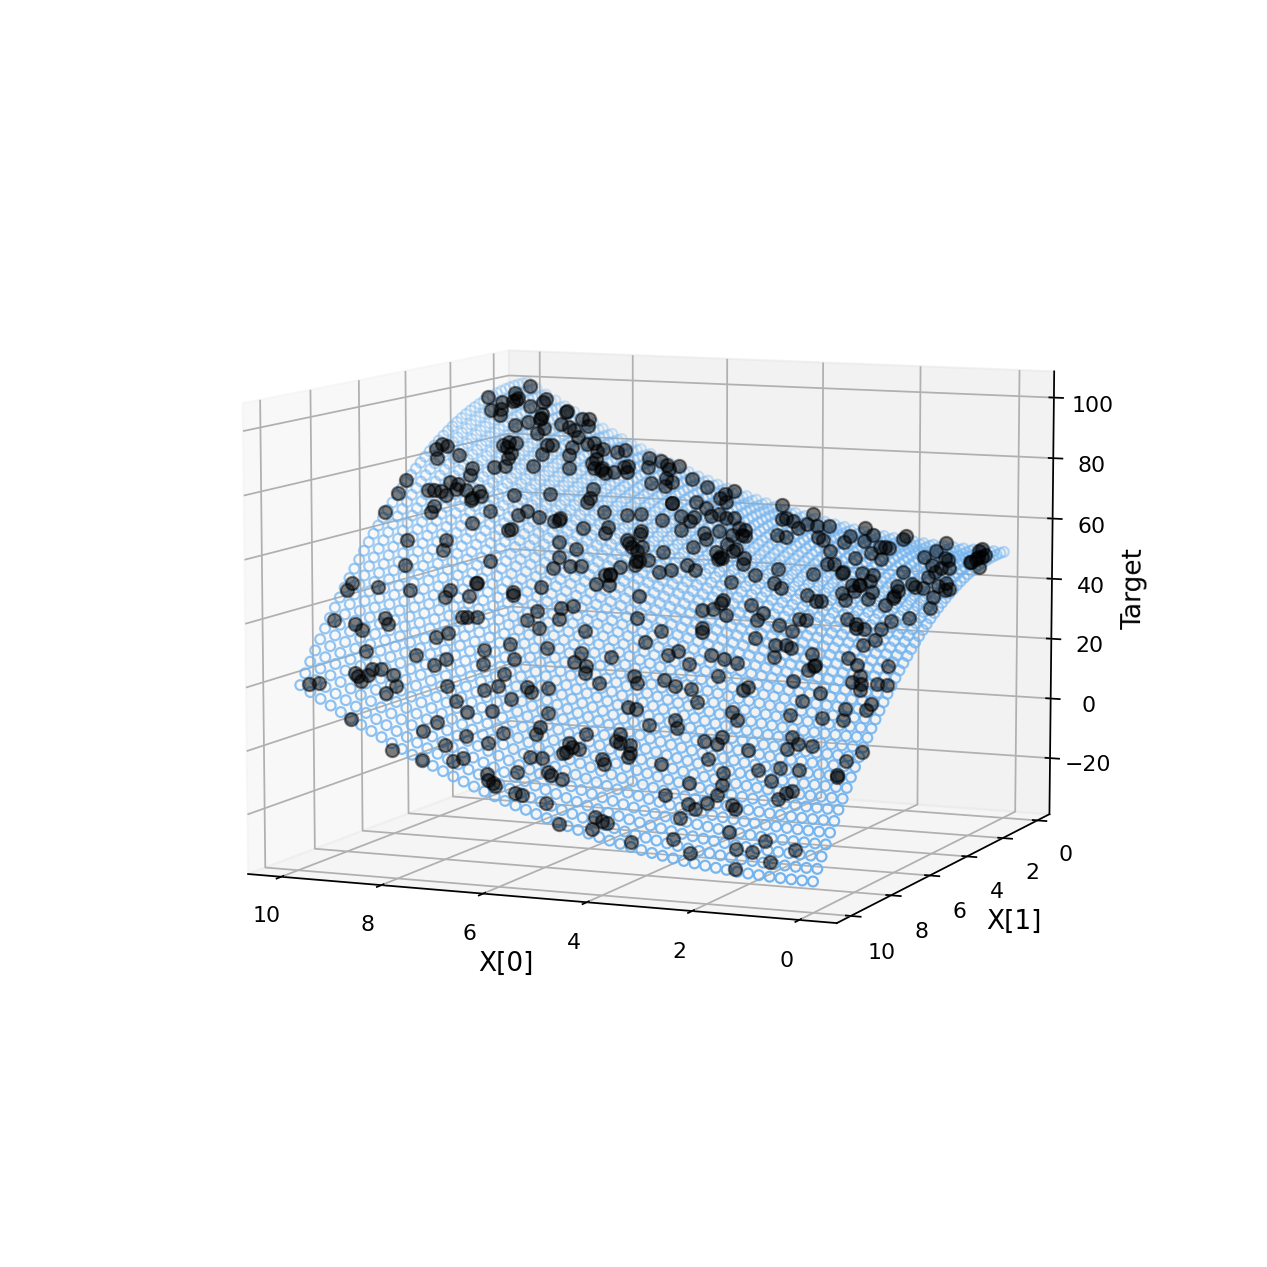

In [26]:
# Makes the plot interactive. 
# You can pan the image.
%matplotlib notebook  
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(X[:,0],X[:,1], y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(Xgrid[:,0], Xgrid[:,1], mod.predict(Xgrid), 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)

I am still a bit confused on RMS error on datapoints that have error themselves. I would assume you could do a weighted average, similar to how the $\chi^2$ handles it, but I just wasn't sure, and it wasn't mentioned in the book, so I stuck with what both lecture notebooks and the book says.

SRT: Indeed, the BIC calculation should have been modified to be the uncertainty-weighted deviation of the model prediction from the data (like a $\chi^2$ since the BIC can be derived from the log-likelihood). This changes the results a little bit, but not dramatically. A quadratic model is still favored. -2 